In [32]:
import matplotlib.pyplot as plt
import math
import numpy as np
import keras_ocr
import cv2
import os
import skimage.io
from skimage import measure
import skimage
from matplotlib import image as mpimg

In [33]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)
pipeline = keras_ocr.pipeline.Pipeline()

def remove_text(img_path, pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(img)

Looking for /Users/aklabjan/.keras-ocr/craft_mlt_25k.h5


2023-03-30 21:15:35.222296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Looking for /Users/aklabjan/.keras-ocr/crnn_kurapan.h5


In [34]:
#create images without words
directory = "images/segmentationImages"
pipeline = keras_ocr.pipeline.Pipeline()
for photo_file in os.listdir(directory):
    if photo_file.startswith("img"):
        path = os.path.join(directory,photo_file,"input.png")
        img = remove_text(path,pipeline)  #returned image is inverted
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert to RGB
        out_path = os.path.join(directory,photo_file,"noWordsOutput.png")
        cv2.imwrite(out_path,img_rgb)

Looking for /Users/aklabjan/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/aklabjan/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 811ms/step


In [70]:
def get_properties(img_path, blur=None):
    # Load image
    img = skimage.io.imread(img_path)
    if blur != None:
        if blur == "gaussian":
            img = skimage.filters.gaussian(img)
        elif blur == 'median':
            img = skimage.filters.median(img)
        elif blur == 'bilateral':
            img = skimage.filters.rank.mean_bilateral(img)
        elif blur == 'total_variation':
            img = skimage.restoration.denoise_tv_chambolle(img)
    # Convert to binary image
    bwimg = img > skimage.filters.threshold_otsu(img)
    # Label connected components in the binary image
    labeled_img = measure.label(bwimg)
    # Compute region properties for each object
    stats = measure.regionprops(labeled_img)

    return stats

def annotate_center(img_path, stats, out_path):
    fig, ax = plt.subplots()
    img = mpimg.imread(img_path)
    ax.imshow(img)
    green_color = [0, 1, 0]
    for obj in stats:
        y, x, z = obj.centroid
        # Retrieve pixel value at (x, y) coordinate
        pixel_value = img[round(y), round(x), :]
        # Compute Euclidean distance between pixel color and green color
        dist = np.linalg.norm(pixel_value - green_color)
        # Define distance threshold
        threshold = 0.85  # Adjust this value based on how close you want the pixel to be to green
        if dist <= threshold: # filter to see if plant part or not
            ax.plot(x, y, 'ro')
    ax.set_axis_off()
    dpi = img.shape[0] / fig.get_size_inches()[0] 
    plt.savefig(out_path, dpi = dpi,  bbox_inches='tight',pad_inches=0)

/var/folders/y9/5tj9lw0j1934b6b3lt2zw7jr0000gp/T/ipykernel_47774/3496781776.py:6: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  img = skimage.filters.gaussian(img)
/var/folders/y9/5tj9lw0j1934b6b3lt2zw7jr0000gp/T/ipykernel_47774/3496781776.py:14: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (763, 1170, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)
/var/folders/y9/5tj9lw0j1934b6b3lt2zw7jr0000gp/T/ipykernel_47774/3496781776.py:14: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1106, 1081, 3) looks like that of an RGB image.
  bwimg = img > skimage.filters.threshold_otsu(img)
/var/folders/y9/5tj9lw0j1934b6b3lt2zw7jr0000gp/T/ipykernel_47774/3496781776.py:14: UserWarning: threshold_otsu is expected

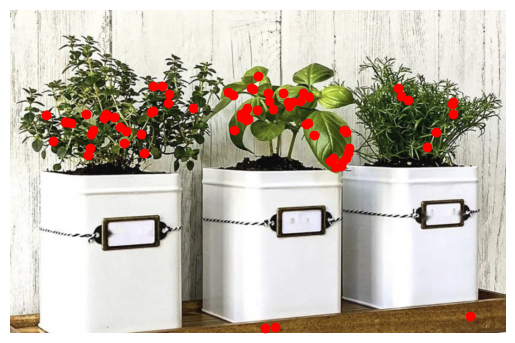

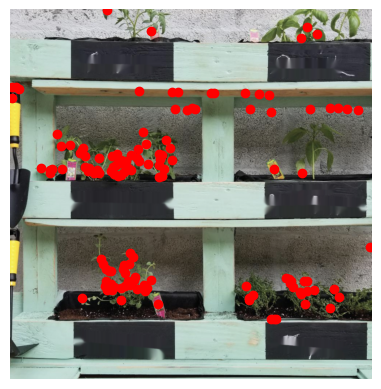

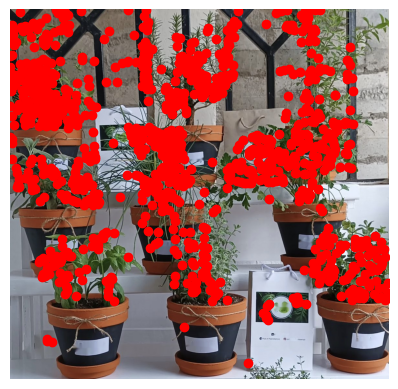

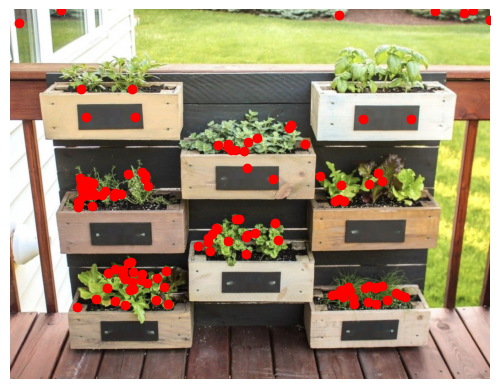

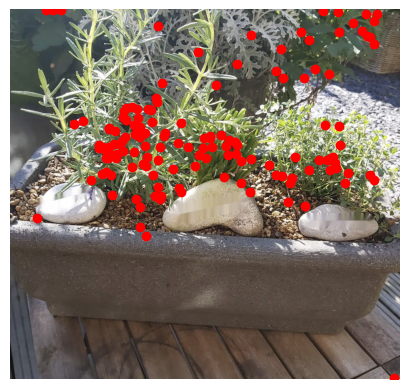

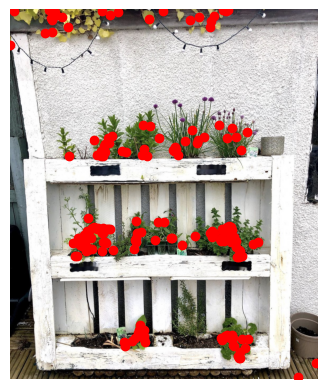

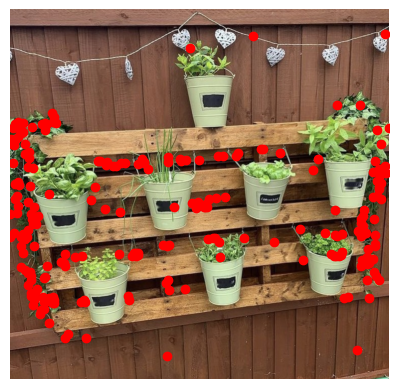

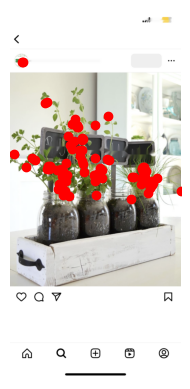

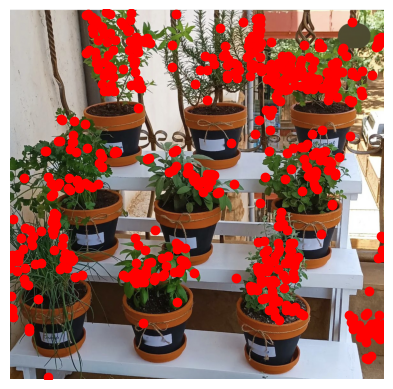

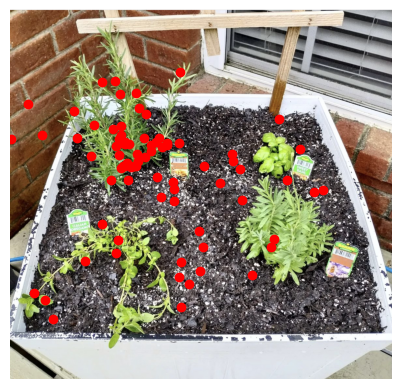

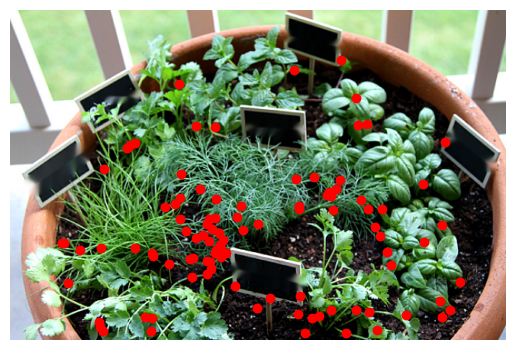

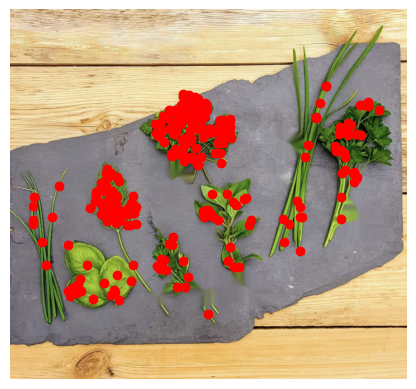

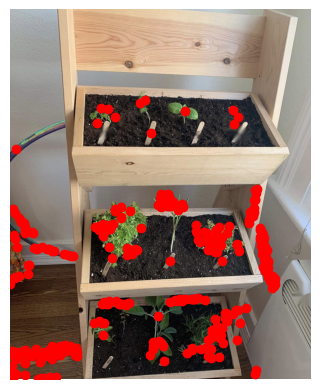

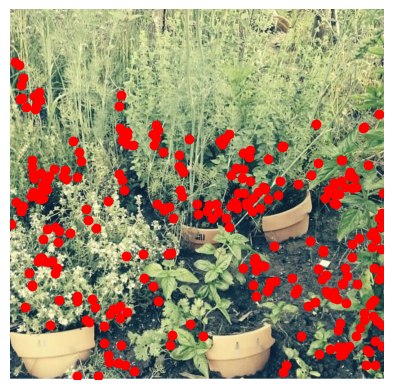

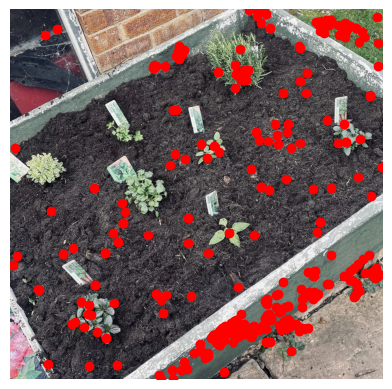

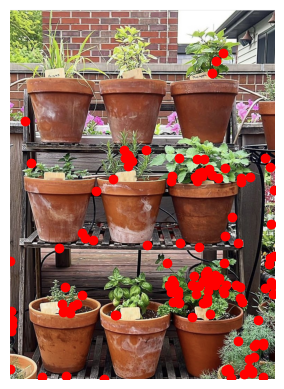

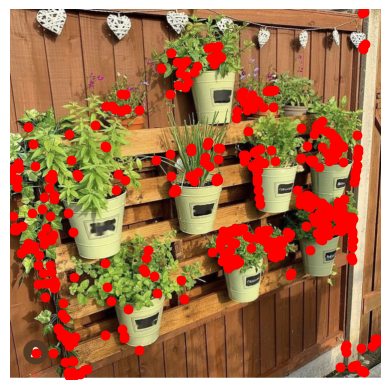

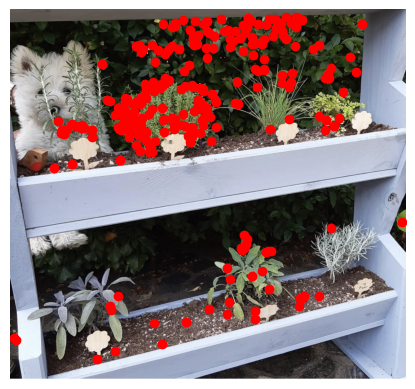

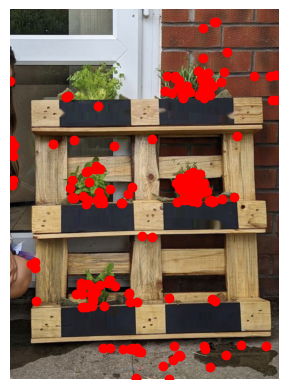

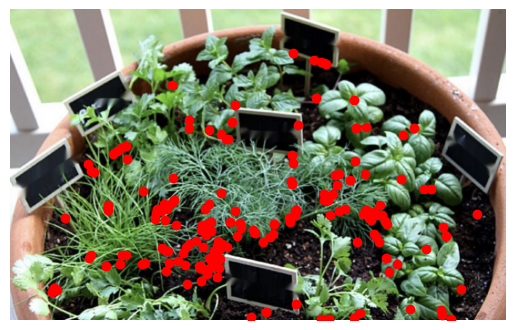

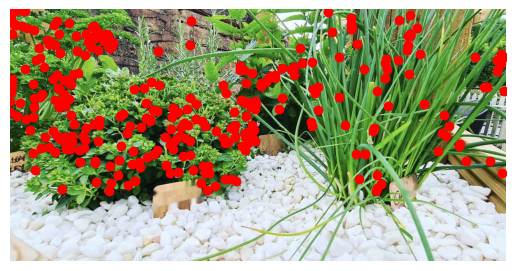

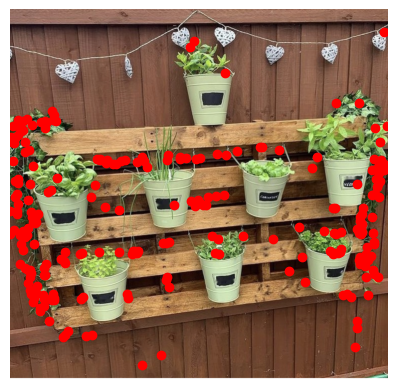

In [71]:
#annotate center
directory = "images/segmentationImages"
for photo_file in os.listdir(directory):
    if photo_file.startswith("img"):
        img_path = os.path.join(directory,photo_file,"noWordsOutput.png")
        stats = get_properties(img_path,'gaussian')
        out_path = os.path.join(directory,photo_file,"annotateCenterOutput.png")
        annotate_center(img_path,stats,out_path)